## Imports

In [1]:
import os 
import sys

import torch

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import clear_output

import importlib

import torch.nn as nn

import time

sys.path.append(os.path.abspath(os.path.join('..')))

# Components

### Image

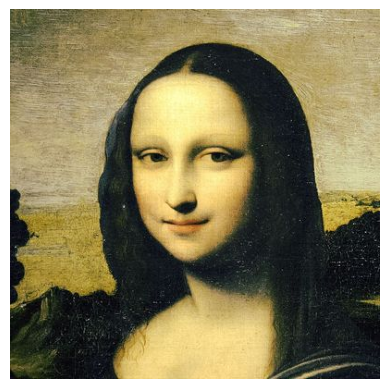

In [2]:
# image from link
url = "https://pyxis.nymag.com/v1/imgs/ccd/8a6/a1c2985ae120955603d45c82ebee96d8d3-29-Mona-Lisa.rsquare.w400.jpg"
# load image from this link
import urllib.request
from PIL import Image

image = Image.open(urllib.request.urlopen(url))

# convert image to numpy array
image = np.array(image)
image = np.array(Image.fromarray(image).resize((400, 400)))

plt.imshow(image)
plt.axis('off')
plt.show()

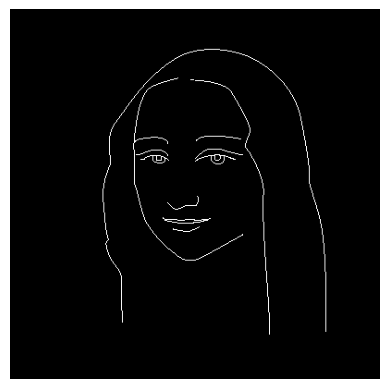

In [3]:
# open viseon/out/edges.png
edges = Image.open('../out/edges.png')
edges = 255-np.array(edges)
# edges = np.array(Image.fromarray(edges).resize((400, 400)))

plt.imshow(edges)
plt.axis('off')
plt.show()

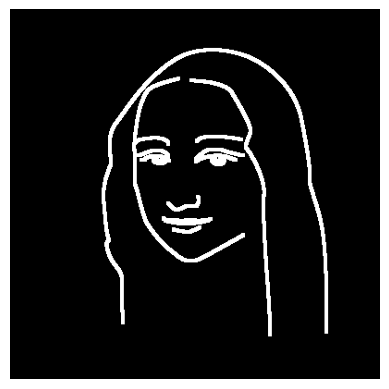

In [13]:
# dilate edges
import cv2
kernel = np.ones((4,4),np.uint8)
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(dilated_edges)
plt.axis('off')
plt.show()

# Simulator

In [5]:
import yaml
import dynaphos
import pickle

import dynaphos
from dynaphos import cortex_models
from dynaphos.utils import Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from utils import resize

from ipywidgets import interact, FloatSlider

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

cfg = load_config('../_config/exp-local/faces_boundary_supervised_phosphenes_no_decoder.yaml')
cfg['retinal_compression'] = True
cfg['data_directory'] = '../../data/face/LaPa'
cfg['fov'] = 5
cfg['base_config'] = '../_config/exp-local/params.yaml'
cfg['phosphene_map'] = '../_config/phosphene_maps/DefaultCoordinateMap_1024_phosphenes.pickle'
cfg['batch_size'] = 1
cfg['resolution'] = [400, 400]
cfg['output_scaling'] = 100.e-6
cfg['n_electrodes'] = 1024


In [6]:
def get_simulator(cfg):
    # initialise simulator
    params = dynaphos.utils.load_params(cfg['base_config'])
    n_phosphenes = cfg['n_electrodes']

    # phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
    # from phosphene map
    with open(cfg['phosphene_map'], 'rb') as f:
        phosphene_coords = pickle.load(f)

    simulator = PhospheneSimulator(params, phosphene_coords)
    # cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
    return simulator, phosphene_coords

simulator, phosphene_coords = get_simulator(cfg)
len(phosphene_coords), len(simulator.phosphene_maps)

(1024, 1024)

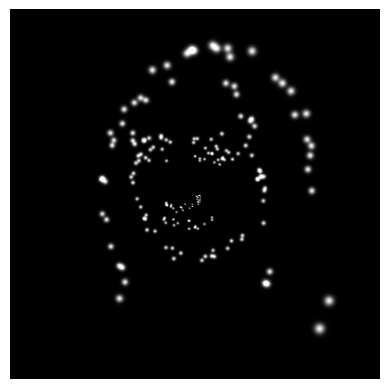

In [18]:
outlines = 0.0002*torch.Tensor(dilated_edges.mean(2)/255).unsqueeze(0).cuda()
simulator.reset()
stimulus = simulator.sample_stimulus(outlines)
phosphenes = simulator(stimulus)

phosphenes = phosphenes.detach().cpu().numpy()

plt.imshow(phosphenes, cmap='gray')
plt.axis('off')
plt.show()


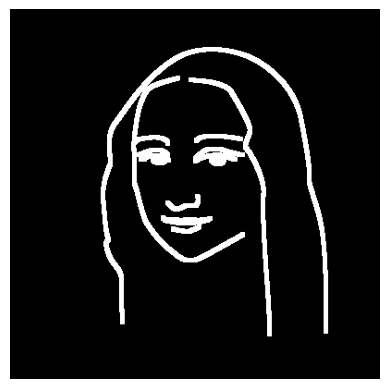

In [9]:
# show outplines
plt.imshow(outlines.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()